In [116]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from numba import jit

In [535]:
x_dim = 2 # dimension of observations
num_clusters = 10
mus = []

sig = np.random.randn(x_dim,x_dim)/np.sqrt(x_dim)
Sigma = sig@sig.T

for i in range(num_clusters):
    mus.append(100*np.random.randn(x_dim,1))
    
per_class_sample = 1000 # number of data points
samples = per_class_sample * num_clusters

In [536]:
classes = []
for i in range(num_clusters):
    classes.append(mus[i] + np.random.randn(x_dim,int(per_class_sample)))

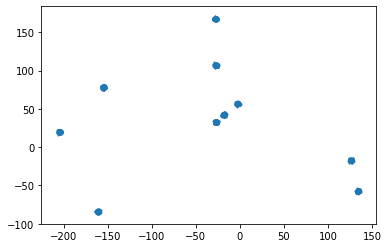

In [537]:
X = np.concatenate(classes, axis=1)
plt.scatter(X[0],X[1],s=1)
plt.show()

In [538]:
Z = np.zeros((2,samples))
Z[0, per_class_sample:] = 1
Z[1, 0:per_class_sample] = 1

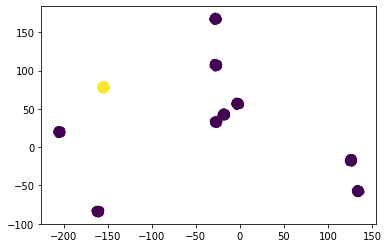

In [539]:
X = np.concatenate(classes, axis=1)
plt.scatter(X[0],X[1],c=Z[1])
plt.show()

## Hard Clustering

In [542]:
W = np.random.randn(num_clusters,x_dim)
theta = np.zeros((num_clusters,1))
n = np.ones((num_clusters,1))
Y = np.zeros((num_clusters,samples))
eta = .01
rho = .5
#idx = np.random.permutation(samples)

#s = np.empty(idx.size, dtype=np.int32)
#for i in np.arange(idx.size):
#    s[idx[i]] = i
    
    
#X = X[:, idx]
#Z = Z[:, idx]
neural = True

def cluster(x, W, theta, n):
    #Initializing Variables

    

    a = -W@x + theta
    y = np.zeros((num_clusters,1))
    z = np.zeros(1)

    if neural: ## Neural Step 3

        er  = 1
        itr = 1

        # Iterate until convergence
        while er > 1e-7:

            z_prev = z
            y_prev = y

        
            
            # Update y and z
            y = np.maximum( 0, y + (eta)*( -a - z - rho*(np.sum(y, axis=0) - 1) ) );
            z += eta*( np.sum(y, axis=0) - 1 )
            

            er = max(np.linalg.norm(z_prev-z)/(np.linalg.norm(z_prev)+1e-4),
                     np.linalg.norm(y_prev-y)/(np.linalg.norm(y_prev)+1e-4))
            itr += 1

    else: ## Non=Neural Step 3
        c = np.argmin(a)
        y[c] = 1
        z = -a[c]

    #Step 4

    n += y

    for i in range(num_clusters):
        for j in range(x_dim):
            W[i,j] += y[i]*(2*x[j] - W[i,j])/n[i]

        theta[i] += y[i]*(z - theta[i])/n[i]

    for j in range(num_clusters):
        Y[j,t] = y[j]
    

for t in tqdm(range(samples)):
    x = X[:,t].reshape((x_dim,1))
    cluster(x, W, theta, n)

for i in range(num_clusters):
    print(f'Cluster {i+1} mean: {W[i,:]/2}')

100%|██████████| 10000/10000 [03:08<00:00, 52.93it/s]

Cluster 1 mean: [-0.00345196  0.67027057]
Cluster 2 mean: [-1.5457548 55.3445788]
Cluster 3 mean: [ 0.17626924 -0.48502104]
Cluster 4 mean: [-1.22718155 -0.10670291]
Cluster 5 mean: [-0.00085069  0.07000347]
Cluster 6 mean: [0.52132347 0.36993722]
Cluster 7 mean: [0.14199218 0.30143891]
Cluster 8 mean: [-0.68675685  0.13435281]
Cluster 9 mean: [ 0.86817511 -0.23379435]
Cluster 10 mean: [1.11383428 0.69902523]


## Calculate Means and Sigma

In [529]:
mu_1 = np.sum(Y[:,per_class_sample:], axis=1)/((num_clusters-1)*per_class_sample)
mu_2 = np.sum(Y[:,:per_class_sample], axis=1)/per_class_sample
Sigma = np.eye(num_clusters)

In [530]:
#e = np.zeros((num_clusters, num_clusters))
#for i in range(num_clusters):
#    e[i,i] = 1

In [531]:
#mu_1 = np.sum([e[i]*per_class_sample for i in range(1,num_clusters)], axis=0)/((num_clusters-1)*per_class_sample)
#mu_2 = e[0]
#Sigma = np.eye(num_clusters)

In [532]:
w_opt = np.linalg.inv(Sigma)@(mu_1-mu_2)
w_opt = w_opt/np.sqrt(w_opt.T@Sigma@w_opt)

/Users/aneeshkashalikar/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [533]:
obj_opt = (w_opt.T@(mu_1-mu_2))**2

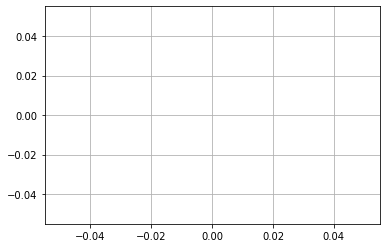

In [534]:
plt.scatter(w_opt.T@Y[:,per_class_sample:],np.zeros((w_opt.T@Y[:,per_class_sample:]).shape),s=10)
plt.scatter(w_opt.T@Y[:,0:per_class_sample],np.zeros((w_opt.T@Y[:,0:per_class_sample]).shape),s=10)

plt.grid()
plt.show()

In [495]:
@jit(nopython=True)
def eta(t):
    return 1e-4/(1+1e-4*t)

gam = 100; epochs = 30; iters = epochs*samples

In [496]:
@jit(nopython=True)
def fit_bio(w, l, mu, x, y, zeta, l_, t):
    z = w.T@x - zeta
    
    step = eta(t)
    
    if y[1] == 0:
        mu += (x - mu)/t
        zeta += z/t
        w += step*(mu - l*z*(x-mu))
        l += gam*step*(z**2 - 1)
        l_ += 1
        
    else:
        w -= step*l_*x
        l_ = 1
        
        
    return w, l, mu, x, y, zeta, l_

def run_bio(X, Y):
    
    w = np.random.randn(num_clusters)/np.sqrt(num_clusters)
    l = 1
    zeta = 0
    l_ = 1
    
    mu = np.zeros(num_clusters)

    for i_epoch in tqdm(range(epochs)):

        idx = np.random.permutation(samples)

        for i_sample in range(samples):

            i_iter = i_epoch*samples + i_sample

            t = i_iter + 1

            x = X[:,idx[i_sample]]
            y = Y[:,idx[i_sample]]

            w, l, mu, x, y, zeta, l_ = fit_bio(w, l, mu, x, y, zeta, l_, t)
            
            obj[i_iter] = (w.T@(mu_1-mu_2))**2/(w.T@Sigma@w)
            err[i_iter] = abs(obj_opt - obj[i_iter])/obj_opt
        
        #print(f'Error: {err_approx[i_iter]}')
    return w

obj = np.zeros(iters)
err = np.zeros(iters)

w = run_bio(Y,Z)

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-496-aa9a5846745a>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  z = w.T@x - zeta
/Users/aneeshkashalikar/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numba/core/typing/npydecl.py:933: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
<ipython-input-496-aa9a5846745a>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  z = w.T@x - zeta
/Users/aneeshkashalikar/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numba/core/typing/npydecl.py:933: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
100%|██████████| 30/30 [00:26<00:00,  1.19it/s]


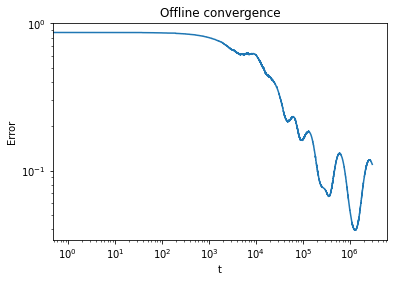

In [497]:
plt.loglog(range(iters), err)
plt.ylabel("Error")
plt.xlabel("t")
plt.title("Offline convergence")
plt.show()

In [502]:
err[-1]

0.11032981602086392

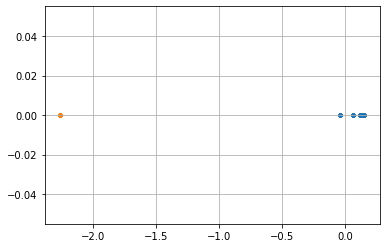

In [503]:
#Y_ = Y[:, s]

plt.scatter(w.T@Y[:,per_class_sample:],np.zeros((w.T@Y[:,per_class_sample:]).shape),s=10)
plt.scatter(w.T@Y[:,0:per_class_sample],np.zeros((w.T@Y[:,0:per_class_sample]).shape),s=10)

plt.grid()
plt.show()

## Soft Clustering

In [18]:
num_clusters = 2
W = np.random.randn(num_clusters,x_dim)
theta = np.zeros((num_clusters,1))
n = np.ones((num_clusters,1))
Y = np.zeros((num_clusters,samples))
eta = .1
rho = 5
idx = np.random.permutation(samples)
neural = True
alpha = 10**-2.5
for t in tqdm(range(samples)):
    
    #Initializing Variables
    x = X[:,idx[t]].reshape((x_dim,1))

    a = -W@x + theta
    y = np.zeros((num_clusters,1))
    z = 0

    if neural: ## Neural Step 3
        
        er  = 1
        itr = 1
        
        # Iterate until convergence
        while er > 1e-7:
        
            z_prev = z
            y_prev = y
            
            # Update y and z
            
            y = np.maximum( 0, y + (eta)*(-alpha*t*y/n -a - z - rho*(np.sum(y) - 1)) );
            z += eta*(np.sum(y) - 1) - 1
            
            
            er = max(np.linalg.norm(z_prev-z)/(np.linalg.norm(z_prev)+1e-4),
                     np.linalg.norm(y_prev-y)/(np.linalg.norm(y_prev)+1e-4))
            itr += 1
        
    else: ## Non-Neural Step 3
        c = np.argmin(a)
        y[c] = 1
        z = -a[c]
    
    ## Step 4
    n += y

    for i in range(num_clusters):
        for j in range(x_dim):
            W[i,j] += y[i]*(2*x[j] - W[i,j])/n[i]

        theta[i] += y[i]*(z - theta[i])/n[i]

    for j in range(num_clusters):
        Y[j,idx[t]] = y[j]

for i in range(num_clusters):
    print(f'Cluster {i+1} mean: {W[i,:]/num_clusters}')

100%|██████████| 1000/1000 [01:13<00:00, 10.85it/s]

Cluster 1 mean: [10.0270086  -0.03370123]
Cluster 2 mean: [-5.59314843e-03  9.92398284e+00]
